## Загрузим нужные библиотеки

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [4]:
df = pd.read_csv("/content/train.csv")

## Рассмотрим датасет по ближе

In [7]:
df.head(3)

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория
0,2246,Помогите начальник Льговского рэс не реагирует...,"Нарушения, связанные с содержанием электросети...",Администрация Льговского района,3
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,Аварийные деревья,Администрация города Курска,3
2,2240,Агресивные собаки. На радуге там стая из подро...,Безнадзорные животные,Администрация города Курска,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2000 non-null   int64 
 1   Текст Сообщения     2000 non-null   object
 2   Тематика            2000 non-null   object
 3   Ответственное лицо  2000 non-null   object
 4   Категория           2000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 78.2+ KB


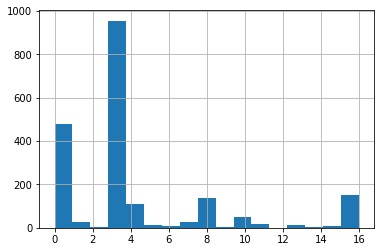

In [13]:
df["Категория"].hist(bins = 17)

Заметен сильный разброс популярности категориий

In [14]:
df["Ответственное лицо"].value_counts()

Администрация города Курска                                          421
Комитет дорожного хозяйства города Курска                            215
Комитет жилищно-коммунального хозяйства города Курска                171
Государственная жилищная инспекция Курской области                   151
Комитет городского хозяйства города Курска                           127
                                                                    ... 
МКУ «Управление по делам ГО и ЧС при Администрации города Курска»      1
Комитет агропромышленного комплекса Курской области                    1
Комитет информации и печати Курской области                            1
Администрация Кореневского района                                      1
ООО `УК `Северный дом`                                                 1
Name: Ответственное лицо, Length: 75, dtype: int64

Сделаем категорию **"Ответственное лицо"** раноговой 

In [16]:
df["Ответственное лицо"] = pd.Categorical(df["Ответственное лицо"])
df["Ответственное лицо"].astype('category').cat.codes
df["Ответственное лицо"] = df["Ответственное лицо"].cat.codes

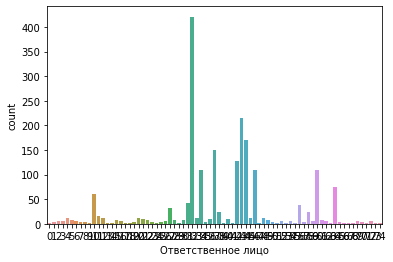

In [19]:
sns.countplot(x = "Ответственное лицо" , data  = df)  

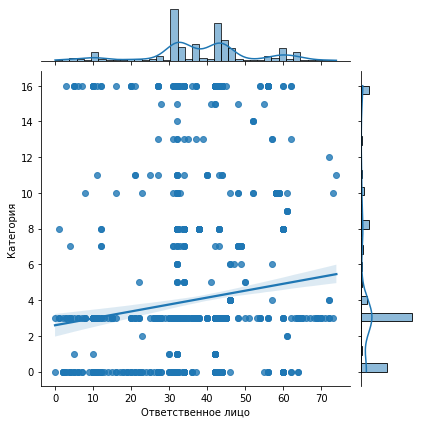

In [20]:
sns.jointplot(x = "Ответственное лицо", y = 'Категория', data = df, kind = 'reg')

Кажется нет четкой зависимости между категорией и ответственным лицом города 

In [21]:
df["Тематика"] = pd.Categorical(df["Тематика"])
df["Тематика"].astype('category').cat.codes
df["Тематика"] = df["Тематика"].cat.codes

Видоизменим категорию **"Тематика"**  

In [26]:
df["Длина Сообщения"] = df["Текст Сообщения"].str.len()

Добавим новый столбец в датсет и взглянем на то что у нас получилось

In [27]:
df.head(3)

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория,Длина Сообщения
0,2246,Помогите начальник Льговского рэс не реагирует...,51,12,3,210
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,2,32,3,650
2,2240,Агресивные собаки. На радуге там стая из подро...,3,32,1,189


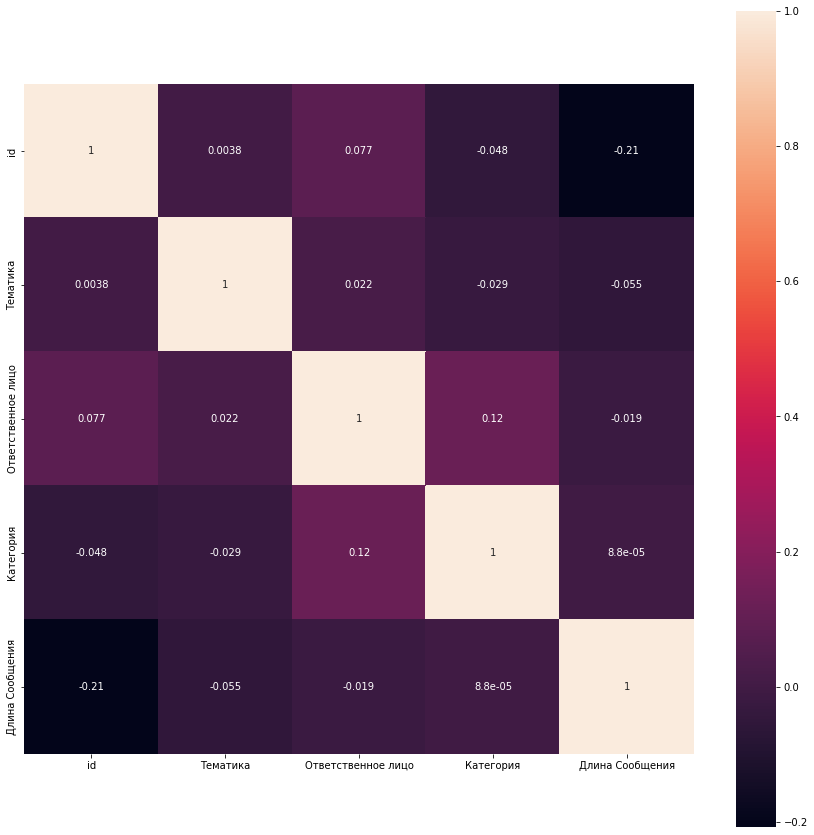

In [28]:
plt.rcParams['figure.figsize']=(15,15)

corr = df.corr()
g = sns.heatmap(corr, square = True, annot=True)

Последняя попытка найти явную зависимость в данных

## Выделим выборки

In [44]:
X = df.drop(["Категория", "Текст Сообщения", "id"], axis = 1)
y = df[["Категория"]]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Обучение модели

In [50]:
clf = RandomForestClassifier(random_state=0)

In [52]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(random_state=0)

## Оценка точности

In [54]:
pred = clf.predict(X_test)

In [67]:
def one_label_to_many(df, classes = [x for x in range(17)]):
    y_test = []
    min_class = min(classes)
    count_class = len(classes)

    for ll in df:
        mass = [0]*count_class
        mass[int(ll) - min_class] = 1
        y_test.append(mass)

    return y_test

In [110]:
y_test["Категория"].value_counts()

3     261
0     147
16     47
8      41
4      39
10     14
1      12
7       8
11      8
5       5
15      4
6       3
13      3
12      2
9       2
14      2
2       2
Name: Категория, dtype: int64

In [109]:
from sklearn.metrics import roc_auc_score

pred_new = one_label_to_many(pred)
y_test["Категория"].iloc[0] = 12
y_test["Категория"].iloc[2] = 14 


score = roc_auc_score(y_test["Категория"], pred_new , multi_class='ovo')

In [111]:
score

0.6753420025869293